<a href="https://colab.research.google.com/github/Paullee6997/DataAnalyticsSpring2020_PaulLee/blob/master/Lee%2CPaul_LSTM_COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
from scipy.stats import loglaplace,chi2
#!pip install matplotlib-label-lines
from labellines import labelLine, labelLines
from pandas import Series
import datetime
from numpy import array
from pylab import rcParams
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation, Dense, RepeatVector, TimeDistributed, Dropout

import pandas as pd
#read in data
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df = pd.read_csv(url)
df.head()
print(df.shape)
#Change column names
df = df.rename(columns={"Province/State":"Province_State", "Country/Region":"Country_Region"})
df.fillna("", inplace=True)
df["Country_Province"] = df["Country_Region"] + df["Province_State"]

df

In [0]:
#Setting options for display 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

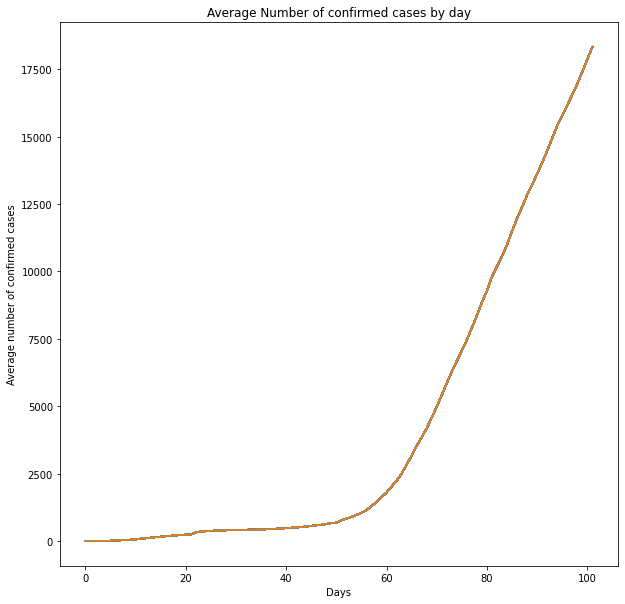

In [619]:
df_eda = df.copy()

confirmed_country = df_eda.groupby("Country_Region").sum()

top_15 = confirmed_country.sort_values(by="5/2/20", ascending=False).head(n=15)

time = [x for x in range(len(top_15.iloc[:,2:].columns))]
plt.figure(figsize=(10,10))
for i in range(len(top_15.iloc[:,2:])):
  plt.plot(time, top_15.iloc[i,2:], label = str(top_15.index[i]))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Top 15 countries with the largest confirmed cases")
plt.xlabel('Days')
plt.ylabel('Confirmed cases')
plt.show()

top_5 = confirmed_country.sort_values(by="5/2/20", ascending=False).head(n=5)
time = [x for x in range(len(top_5.iloc[:,2:].columns))]
plt.figure(figsize=(10,10))
for i in range(len(top_5.iloc[:,2:])):
  plt.plot(time, top_5.iloc[i,2:], label = str(top_5.index[i]))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Top 5 countries with the largest confirmed cases")
plt.xlabel('Days')
plt.ylabel('Confirmed cases')
plt.show()

#Make a array of growth changes for every country where for each country we have a list
#make df using the array for arrays of growth by country with column names coming from confirmed_country.columns[2:]

growth_array_holder = []
for country in range(len(confirmed_country)):
  country_growth = []
  for day in range(len(confirmed_country.columns[2:])):
    if day == 101:
      break
    else:
      country_growth.append(abs(confirmed_country.iloc[country,2:].iloc[day] - confirmed_country.iloc[country,2:].iloc[day+1]))
  growth_array_holder.append(country_growth)

cf_growth_country = pd.DataFrame(growth_array_holder, columns = confirmed_country.columns[2:103])
cf_growth_country.index = confirmed_country.index.values

avg_growth =[]
for i in range(len(cf_growth_country)):
  avg_growth.append(sum(cf_growth_country.iloc[i])/len(cf_growth_country))
cf_growth_country["Avg_growth"] = avg_growth

top_15_growth = cf_growth_country.sort_values(by="Avg_growth", ascending=False).head(n=15)
time = [x for x in range(len(top_15_growth.columns)-1)]
plt.figure(figsize=(10,10))
for i in range(len(top_15_growth)):
  plt.plot(time, top_15_growth.iloc[i,:101], label = str(top_15.index[i]))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Top 15 countries with the largest average increase in confirmed cases by country")
plt.xlabel('Days')
plt.ylabel('Increase in confirmed cases from previous day')
plt.show()

from scipy.ndimage.filters import gaussian_filter1d

top_5_growth = cf_growth_country.sort_values(by="Avg_growth", ascending=False).head(n=5)
time = [x for x in range(len(top_5_growth.columns)-1)]
plt.figure(figsize=(10,10))
for i in range(len(top_5_growth)):
  ysmoothed = gaussian_filter1d(top_5_growth.iloc[i,:101], sigma=2)
  plt.plot(time, ysmoothed, label = str(top_5.index[i]))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Smoothed Top 5 countries with the largest average increase in confirmed cases by country")
plt.xlabel('Days')
plt.ylabel('Increase in confirmed cases from previous day')
plt.show()


plt.figure(figsize=(5,5))
plt.barh(top_15_growth.index.values, top_15_growth.Avg_growth)
plt.title("Top 15 countries with the largest average increase in confirmed cases by country ")
plt.xlabel('Average increase in confirmed cases by day')
plt.ylabel('Countries')
plt.show()

date_stats = confirmed_country.describe(include=np.number).drop('count').T

time = [x for x in range(len(date_stats)-2)]
plt.figure(figsize=(10,10))
for i in range(len(date_stats)-2):
  plt.plot(time, date_stats.iloc[:,0][2:])
plt.title("Average Number of confirmed cases by day")
plt.xlabel('Days')
plt.ylabel('Average number of confirmed cases')
plt.show()


In [0]:
df_train = df.copy()
df_train = df_train.drop(columns=["Province_State","Country_Region","Lat","Long"])

date = []
confirmed = []
countries = []
for i in range(len(df_train.Country_Province)):
  for j in range(len(df_train.columns)-1):
    date.append(df_train.columns[j])
    countries.append(df_train.Country_Province[i])
    confirmed.append(df_train.iloc[i,j])

country_dates_confirmed = {"Date": date, "Countries": countries, "Confirmed": confirmed} 
train = pd.DataFrame(country_dates_confirmed, columns = ["Date","Countries","Confirmed"])

print(train.loc[train["Countries"] == 'Afghanistan'])
train["Date"] = pd.to_datetime(train["Date"])

train["Week_of_Year"] = train["Date"].dt.weekofyear
train["Quarter"] = train["Date"].dt.quarter
train["Month"] = train["Date"].dt.month
train["Day_of_Year"] = train["Date"].dt.dayofyear

ts_train = train.copy()

label_encoding = LabelEncoder()
train["Country_Code"] = label_encoding.fit_transform(train["Countries"])
train.drop(columns=["Countries"], inplace=True)
train


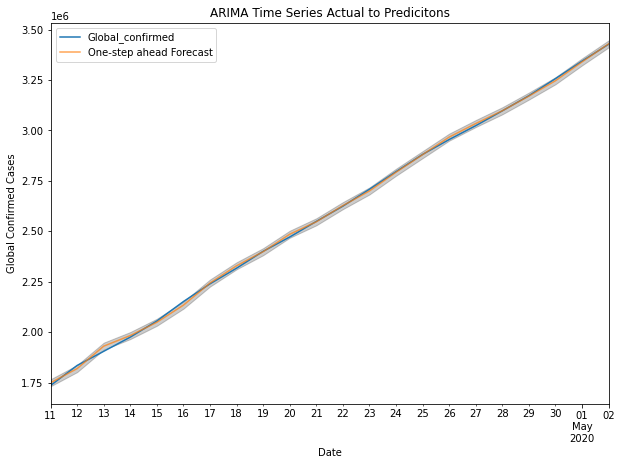

In [638]:
daily_confirmed = []
for i in range(len(confirmed_country.columns)-2):
  daily_confirmed.append(sum(confirmed_country.iloc[:,2:].iloc[:,i]))
date_glo_dict = {"Date":confirmed_country.columns[2:] , "Global_confirmed": daily_confirmed }
ts_global_confirmed = pd.DataFrame(date_glo_dict, columns = ["Date","Global_confirmed"])

ts_global_confirmed.plot(x="Date",y="Global_confirmed", figsize=(20,10))
plt.title("Number of Global confirmed cases over time")
plt.xlabel('Date')
plt.ylabel('Global Confirmed')
plt.show()

ts_global_confirmed["Date"] = pd.to_datetime(ts_global_confirmed["Date"])
ts_global_confirmed = ts_global_confirmed.set_index("Date")

decomposition = sm.tsa.seasonal_decompose(ts_global_confirmed["Global_confirmed"], model='additive')

fig = decomposition.plot()
plt.show()

ts_train = ts_global_confirmed[:80]
ts_test = ts_global_confirmed[80:]

#ARIMA GRID_SEARCH CREDIT TO SUSAN LI FROM Towardsdatascience

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

score = 100000000 
for param in pdq:
  for param_seasonal in seasonal_pdq:
      mod = sm.tsa.statespace.SARIMAX(ts_train, order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
      results = mod.fit()
      if results.aic < score:
        score = results.aic
        optimal_params = (param, param_seasonal, results.aic)

print(optimal_params)
optimal_params[0]

final_arima_mod = sm.tsa.statespace.SARIMAX(ts_global_confirmed, order=optimal_params[0],
                                      seasonal_order=optimal_params[1],
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
final_mod_fit = final_arima_mod.fit()
final_mod_fit.summary()

final_mod_fit.plot_diagnostics(figsize=(20,10))
plt.show()

arima_pred = final_mod_fit.get_prediction(start=pd.to_datetime("2020-04-11"), dynamic=False)
arima_pred_ci = arima_pred.conf_int()

ax = ts_global_confirmed["2020-01-22":].plot(label='observed')
arima_pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(10, 7))
ax.fill_between(arima_pred_ci.index,
                arima_pred_ci.iloc[:, 0],
                arima_pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Global Confirmed Cases')
plt.title("ARIMA Time Series Actual to Predicitons")
plt.legend()
plt.show()




In [0]:
#Create lag variables for every row and every country
#CREDIT TO MRMORJ FROM KAGGLE FOR FUNCTION
#CAREFUL RUNNING THIS BLOCK OF CODE WILL TAKE LONG TIME

for i in train["Date"].drop_duplicates():
  for j in train["Country_Code"].drop_duplicates():
    org_mask = (train["Date"] == i) & (train["Country_Code"] == j)
    for lag in range(1,10):
      mask_loc = (train["Date"] == (i - timedelta(days=lag))) & (train["Country_Code"] == j)
      try:
          train.loc[org_mask, 'Confirmed_' + str(lag)]=train.loc[mask_loc, "Confirmed"].values
      except:
          train.loc[org_mask, 'Confirmed_' + str(lag)]=0.0



In [0]:
#from google.colab import drive
#drive.mount('/content/drive')
#train.to_csv(r"/content/drive/My Drive/LSTM_Preprocess_Train.csv")

In [0]:
x_vars = []
for i in range(len(train.columns)):
  if(i >= 2):
    x_vars.append(train.columns[i])
train_x = train[x_vars]
train_x = train_x.values.reshape(train_x.shape[0], 1, train_x.shape[1])

train_y = train["Confirmed"]
train_y = train_y.values.reshape(-1,1)

train_x_confirmed, test_x_confirmed, train_y_confirmed, test_y_confirmed = train_test_split(train_x, train_y, test_size=.2, random_state=0)

In [329]:
def rmsle(prediction, true):
  assert(prediction.shape[0] == true.shape[0])
  return K.sqrt(K.mean(K.square(K.log(prediction+1) - K.log(true+1))))

#Create lstm nn
all_model = Sequential()
#important to set correct input_shape(*tuple*dimensions)
all_model.add(LSTM(100, activation = "relu", input_shape = (train_x_confirmed.shape[1], train_x_confirmed.shape[2])))
all_model.add(Dropout(0.2))
all_model.add(Dense(64, activation = "relu"))
all_model.add(Dense(32, activation = "relu"))
all_model.add(Dense(1, activation = "relu"))
all_model.compile(optimizer='adam', loss=rmsle)

es = EarlyStopping(monitor='val_loss', min_delta = 0, verbose=0, patience=10, mode='auto')
model_checks = ModelCheckpoint('model_confirmed_checks.txt', monitor='val_loss', verbose=0, save_best_only=True)

#fit data
confirmed_fit = all_model.fit(train_x_confirmed, train_y_confirmed, validation_data=(test_x_confirmed,test_y_confirmed), epochs=200, batch_size=512, callbacks=[es,model_checks])

Epoch 1/200
43/43 [==============================] - 3s 60ms/step - loss: 0.7314 - val_loss: 0.3224
Epoch 2/200
43/43 [==============================] - 2s 51ms/step - loss: 0.2591 - val_loss: 0.2042
Epoch 3/200
43/43 [==============================] - 2s 50ms/step - loss: 0.1968 - val_loss: 0.2005
Epoch 4/200
43/43 [==============================] - 2s 57ms/step - loss: 0.2001 - val_loss: 0.1730
Epoch 5/200
43/43 [==============================] - 2s 50ms/step - loss: 0.1763 - val_loss: 0.1629
Epoch 6/200
43/43 [==============================] - 2s 55ms/step - loss: 0.1701 - val_loss: 0.1523
Epoch 7/200
43/43 [==============================] - 0s 10ms/step - loss: 0.1634 - val_loss: 0.1545
Epoch 8/200
43/43 [==============================] - 0s 9ms/step - loss: 0.1714 - val_loss: 0.1537
Epoch 9/200
43/43 [==============================] - 0s 10ms/step - loss: 0.1663 - val_loss: 0.1793
Epoch 10/200
43/43 [==============================] - 0s 9ms/step - loss: 0.1716 - val_loss: 0.1658
E

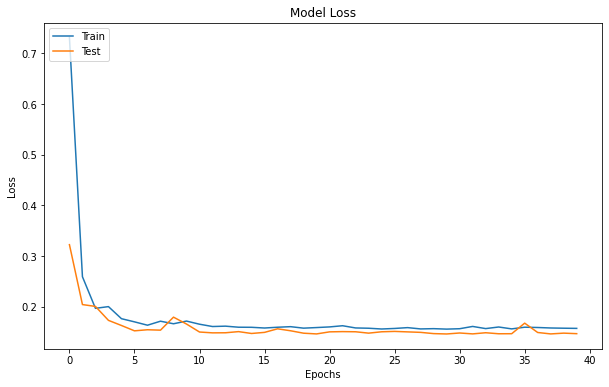

In [652]:
plt.figure(figsize=(10,6))
plt.plot(confirmed_fit.history['loss'], label='Train')
plt.plot(confirmed_fit.history['val_loss'], label='Test')
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

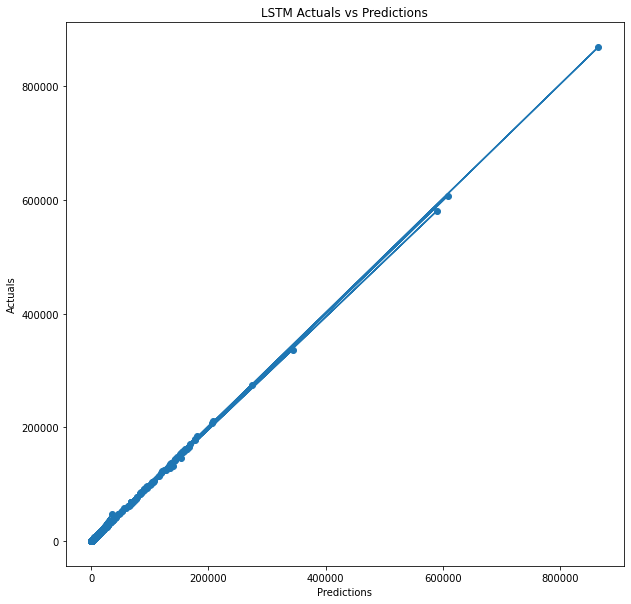

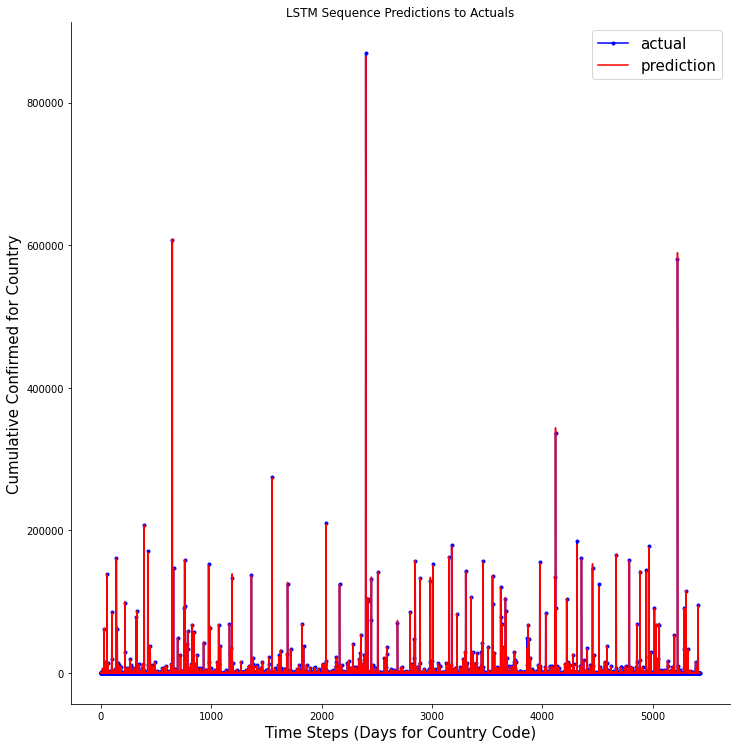

In [632]:
test_pred = all_model.predict(test_x_confirmed)
aa=[x for x in range(5427)]

plt.figure(figsize=(10,10))
plt.scatter(test_pred, test_y_confirmed)
plt.plot(test_pred, test_y_confirmed)
plt.title("LSTM Actuals vs Predictions")
plt.xlabel("Predictions")
plt.ylabel("Actuals")
plt.show();

q_y =[]
for i in range(5427):
  q_y.append(test_y_confirmed[i][0])
q_y

q_y_pred = []
for i in range(5427):
  q_y_pred.append(test_pred[i][0])
q_y_pred[:5427]

plt.figure(figsize=(10,10))
plt.plot(aa, q_y[:5427], marker='.', color="blue", label="actual")
plt.plot(aa, q_y_pred[:5427], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title("LSTM Sequence Predictions to Actuals")
plt.ylabel('Cumulative Confirmed for Country', size=15)
plt.xlabel('Time Steps (Days for Country Code)', size=15)
plt.legend(fontsize=15)
plt.show();